## Load Dependencies

In [1]:
import urllib.request
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

from library import AutoEDA
from library import Explore

from library import create_windowed_df
from library import make_fourier
from library import harmonic_regression
from library import perform_pca
from library import biplot
from library import create_scree_plot

In [2]:
# Convert the XML of the last 90 days of exchange rates from the ECB website to a pandas DataFrame

last_90 = "https://www.ecb.europa.eu/stats/eurofxref/eurofxref-hist-90d.xml?9531d63dc137832dc128c3fcc9bc4f12"

with urllib.request.urlopen(last_90) as response:
   xml_data = response.read()

root = ET.fromstring(xml_data)

df = pd.DataFrame(columns=['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF'],
                  dtype=np.dtype('float64'))
df.index = df.index.astype(np.dtype('datetime64[ns]'))

cube = root.find('{http://www.ecb.int/vocabulary/2002-08-01/eurofxref}Cube')

currencies_lst = ['USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF']
dates = []
currencies_dict = {}

for child in cube:
    dates.append(child.attrib['time'])
    for rate_tag in child:
        currency = list(rate_tag.attrib.values())[0]
        rate = list(rate_tag.attrib.values())[1]
        if currency in currencies_lst:
            if currency in currencies_dict:
                currencies_dict[currency].append(rate)
            else:
                currencies_dict[currency] = [rate]

df = pd.DataFrame.from_dict(currencies_dict, dtype=np.dtype('float64'))
df['date'] = dates
df = df.set_index('date').rename_axis(None)
df.index = df.index.astype(np.dtype('datetime64[ns]'))

USD = df[['USD']]

df.head()

,USD,JPY,BGN,CZK,DKK,GBP,CHF
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766
2024-03-27,1.0816,163.52,1.9558,25.319,7.4582,0.85768,0.9811


In [3]:
obj = AutoEDA(USD, 'USD')
dates_df = obj.append_datetime_cols()

In [4]:
dates_df

,USD,year,month,day,week_of_year,week_of_month,day_of_week
2024-04-04,1.0852,2024,4,4,14,1,4
2024-04-03,1.0783,2024,4,3,14,1,3
2024-04-02,1.0749,2024,4,2,14,1,2
2024-03-28,1.0811,2024,3,28,13,4,4
2024-03-27,1.0816,2024,3,27,13,4,3
...,...,...,...,...,...,...,...
2024-01-12,1.0942,2024,1,12,2,2,5
2024-01-11,1.0987,2024,1,11,2,2,4
2024-01-10,1.0946,2024,1,10,2,2,3
2024-01-09,1.0940,2024,1,9,2,2,2


In [5]:
fourier_df = make_fourier(dates_df, ['month', 'day', 'week_of_year', 'week_of_month', 'day_of_week'])
display(fourier_df.head())

,USD,year,month_sin1,month_cos1,day_sin1,day_cos1,week_of_year_sin1,week_of_year_cos1,week_of_month_sin1,week_of_month_cos1,day_of_week_sin1,day_of_week_cos1
2024-04-04,1.0852,2024,-2.449294e-16,1.000000e+00,0.724793,0.688967,-0.0,1.0,0.951057,0.309017,-0.951057,0.309017
2024-04-03,1.0783,2024,-2.449294e-16,1.000000e+00,0.571268,0.820763,-0.0,1.0,0.951057,0.309017,-0.587785,-0.809017
2024-04-02,1.0749,2024,-2.449294e-16,1.000000e+00,0.394356,0.918958,-0.0,1.0,0.951057,0.309017,0.587785,-0.809017
2024-03-28,1.0811,2024,-1.000000e+00,-1.836970e-16,-0.571268,0.820763,-0.433884,0.900969,-0.951057,0.309017,-0.951057,0.309017
2024-03-27,1.0816,2024,-1.000000e+00,-1.836970e-16,-0.724793,0.688967,-0.433884,0.900969,-0.951057,0.309017,-0.587785,-0.809017


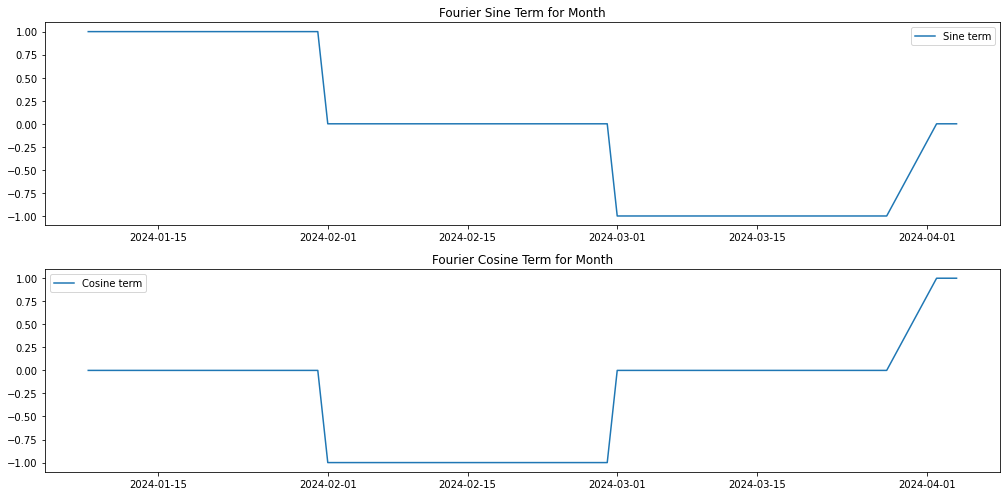

In [6]:
# Generate the Fourier terms
fourier_df = make_fourier(dates_df, ['month', 'day', 'week_of_year', 'week_of_month', 'day_of_week'])

# Plot the Fourier terms
plt.figure(figsize=(14, 7))

# Plot the sine term
plt.subplot(2, 1, 1)
plt.plot(fourier_df.index, fourier_df['month_sin1'], label='Sine term')
plt.title('Fourier Sine Term for Month')
plt.legend()

# Plot the cosine term
plt.subplot(2, 1, 2)
plt.plot(fourier_df.index, fourier_df['month_cos1'], label='Cosine term')
plt.title('Fourier Cosine Term for Month')
plt.legend()

plt.tight_layout()
plt.show()

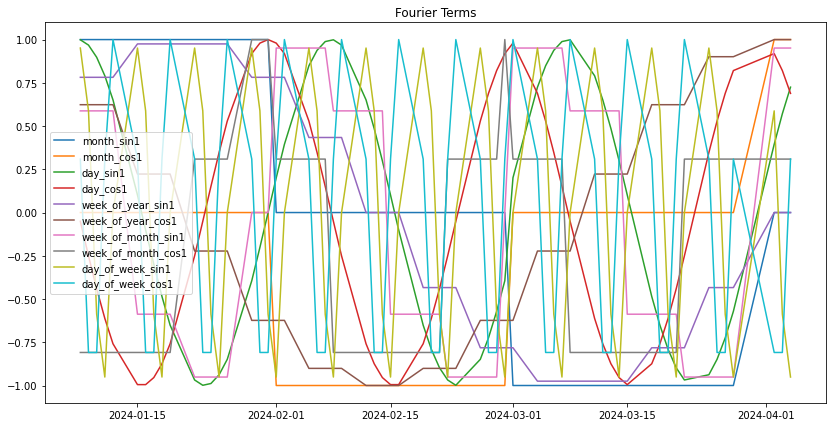

In [7]:
plt.figure(figsize=(14, 7))

# Assuming you have sine and cosine terms for multiple frequencies (e.g., month, day, etc.)
for col in fourier_df.columns:
    if 'sin' in col or 'cos' in col:
        plt.plot(fourier_df.index, fourier_df[col], label=col)

plt.title('Fourier Terms')
plt.legend()
plt.show()


### Harmonic Regression

In [8]:
obj = AutoEDA(USD, 'USD')
dates_df = obj.append_datetime_cols()


In [9]:
harmonic_cols = [col for col in dates_df.columns if 'sin' in col or 'cos' in col]

In [10]:
# Fit harmonic regression to the 'USD' time series
model, df_with_preds = harmonic_regression(dates_df, 'USD', harmonic_cols)

# Display model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    USD   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 05 Apr 2024   Prob (F-statistic):                nan
Time:                        06:40:05   Log-Likelihood:                 227.31
No. Observations:                  62   AIC:                            -452.6
Df Residuals:                      61   BIC:                            -450.5
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0850      0.001   1369.599      0.0

In [11]:
# Display the head of the DataFrame with predictions
print(df_with_preds.head())

               USD  year  month  day  week_of_year  week_of_month  \
2024-04-04  1.0852  2024      4    4            14              1   
2024-04-03  1.0783  2024      4    3            14              1   
2024-04-02  1.0749  2024      4    2            14              1   
2024-03-28  1.0811  2024      3   28            13              4   
2024-03-27  1.0816  2024      3   27            13              4   

            day_of_week  predicted  
2024-04-04            4   1.084969  
2024-04-03            3   1.084969  
2024-04-02            2   1.084969  
2024-03-28            4   1.084969  
2024-03-27            3   1.084969  


In [12]:
# see https://www.youtube.com/watch?v=S_Z8RnTE5dI ~52:00 minute mark

eleven_window = create_windowed_df(USD, 10, 'USD')
display(eleven_window.head(11))

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

X = eleven_window.drop('USD', axis=1)  
y = eleven_window['USD']  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train, y_train)

predictions = rf_regressor.predict(X_test)

mse = mean_squared_error(y_test, predictions)
print('Mean Squared Error:', mse)

,USD_t-10,USD_t-9,USD_t-8,USD_t-7,USD_t-6,USD_t-5,USD_t-4,USD_t-3,USD_t-2,USD_t-1,USD
2024-01-22,1.0946,1.0940,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890
2024-01-23,1.0940,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872
2024-01-24,1.0946,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905
2024-01-25,1.0987,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893
2024-01-26,1.0942,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871
2024-01-29,1.0945,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823
2024-01-30,1.0882,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846
2024-01-31,1.0877,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837
2024-02-01,1.0875,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837,1.0814
2024-02-02,1.0887,1.0890,1.0872,1.0905,1.0893,1.0871,1.0823,1.0846,1.0837,1.0814,1.0883


Mean Squared Error: 2.0678955000002172e-05


## Data Augmentation

In [13]:
#Extracting Spy closing prices into dataframe

spy = yf.Ticker("SPY")
spy_hist = spy.history(period="6mo")
spy_hist = spy_hist[['Close']]
spy_hist.index = spy_hist.index.date
spy_hist

c:\Users\Mayukh Sen\AppData\Local\Programs\Python\Python310\lib\site-packages\yfinance\utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


,Close
2023-10-05,421.476318
2023-10-06,426.480408
2023-10-09,429.210815
2023-10-10,431.444794
2023-10-11,433.212128
...,...
2024-03-28,523.070007
2024-04-01,522.159973
2024-04-02,518.840027
2024-04-03,519.409973


In [14]:
#Performing Data Augmentation and Merging
df_augmented = pd.merge(df, spy_hist, left_index=True, right_index=True, how='left')
df_augmented = df_augmented.dropna()
df_augmented

,USD,JPY,BGN,CZK,DKK,GBP,CHF,Close
2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846,513.070007
2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792,519.409973
2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765,518.840027
2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766,523.070007
2024-03-27,1.0816,163.52,1.9558,25.319,7.4582,0.85768,0.9811,523.169983
2024-03-26,1.0855,164.40,1.9558,25.277,7.4590,0.85846,0.9810,518.809998
2024-03-25,1.0835,163.78,1.9558,25.266,7.4585,0.85698,0.9724,519.770020
2024-03-22,1.0823,163.74,1.9558,25.371,7.4581,0.85795,0.9729,521.210022
2024-03-21,1.0907,164.96,1.9558,25.243,7.4579,0.85678,0.9766,522.200012
2024-03-20,1.0844,164.54,1.9558,25.289,7.4572,0.85438,0.9658,520.479980


<Axes: >

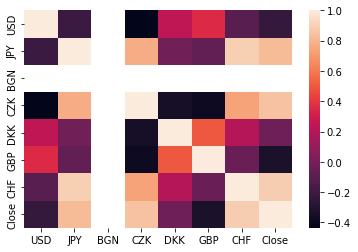

In [15]:
corr = df_augmented.corr()
sns.heatmap(corr)



## Principal Component Analysis

In [16]:
# Perform PCA on the exchange rate data
pca, pc_df = perform_pca(df_augmented, n_components=None)

## PCA Biplot

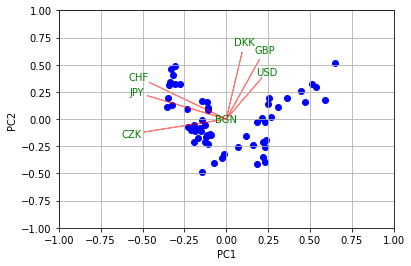

In [17]:
# Assuming `pc_df` is the DataFrame of principal components
# and `pca` is your PCA object after fitting the data
biplot(pc_df.values[:, :2], np.transpose(pca.components_[0:2, :]), labels=df.columns.values[:pca.components_.shape[1]])
plt.show()


## Scree Plot

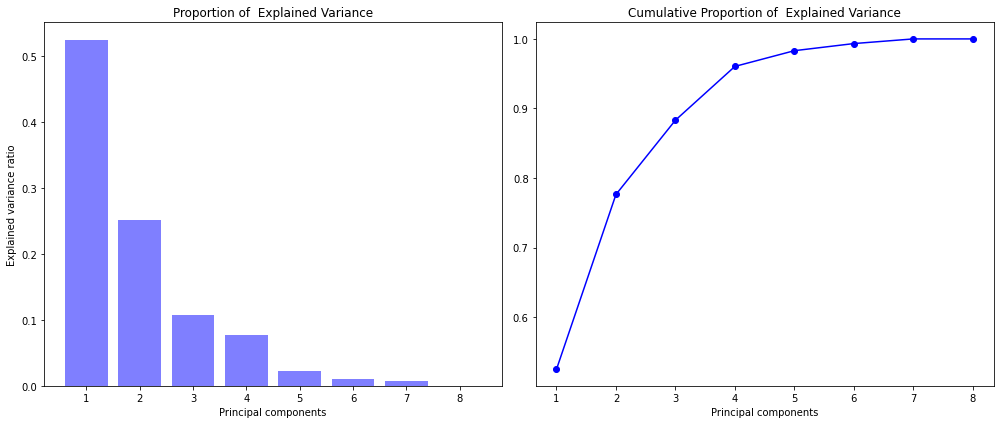

In [18]:
# Create a scree plot to visualize the explained variance
create_scree_plot(pca)

## Interactive plots using Plotly

In [19]:
import plotly.express as px

In [22]:
df

,Date,USD,JPY,BGN,CZK,DKK,GBP,CHF
0,2024-04-04,1.0852,164.69,1.9558,25.322,7.4589,0.85788,0.9846
1,2024-04-03,1.0783,163.66,1.9558,25.352,7.4589,0.85713,0.9792
2,2024-04-02,1.0749,163.01,1.9558,25.361,7.4582,0.85510,0.9765
3,2024-03-28,1.0811,163.45,1.9558,25.305,7.4580,0.85510,0.9766
4,2024-03-27,1.0816,163.52,1.9558,25.319,7.4582,0.85768,0.9811
...,...,...,...,...,...,...,...,...
57,2024-01-12,1.0942,159.17,1.9558,24.689,7.4565,0.85950,0.9350
58,2024-01-11,1.0987,159.71,1.9558,24.659,7.4568,0.86145,0.9338
59,2024-01-10,1.0946,159.03,1.9558,24.562,7.4582,0.86023,0.9336
60,2024-01-09,1.0940,157.63,1.9558,24.594,7.4577,0.85938,0.9313


In [31]:

# Assuming 'df' is your DataFrame with a DateTimeIndex
#df.reset_index(inplace=True)
#df.rename(columns={'index': 'Date'}, inplace=True)

# Melting the DataFrame to have currency names as a single column and their values in another
# Melting the DataFrame for use with Plotly Express
df_melted = df.melt(id_vars=['Date'], var_name='Currency', value_name='Value')

# Create the interactive plot with animation

fig = px.scatter(df_melted,
                 x='Date',
                 y='Value',
                 color='Currency',  # Differentiate each currency by color
                 size='Value',  # Use value to determine the size of the scatter points
                 size_max=15,  # Set the maximum marker size
                 animation_frame=df_melted['Date'].dt.strftime('%Y-%m-%d'),  # Use YearMonth for animation
                 hover_name='Currency',  # Display currency name on hover
                 title='Monthly Currency Exchange Rates Over Time')

# Show the plot
fig.show()


ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['Date', 'USD', 'JPY', 'BGN', 'CZK', 'DKK', 'GBP', 'CHF'] but received: Value